# Imports

In [242]:
import numpy as np
import matplotlib.pyplot as plt

# Activation functions

In [243]:
class ActivationFunction:
    def __init__(self) -> None:
        pass

    def __call__(self, x: np.ndarray) -> np.ndarray:
        raise NotImplemented

    def compute_derivative(self, x: np.ndarray) -> np.ndarray:
        raise NotImplemented

In [244]:
class ReLU(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        y = np.abs(x)
        return 1/2*(x+y)
    def OneCall(self, x: np.ndarray) -> np.ndarray:
        if x > 0:
            return 1
        if x == 0:
            return 1/2
        return 0
    def compute_derivative(self, x: np.ndarray) -> np.ndarray:
        retarray = np.vectorize(self.OneCall)
        return retarray(x)

In [245]:
class Linear(ActivationFunction):
    def __init__(self, k : float):
        self.k = k
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.k*x
    def compute_derivative(self, x: np.ndarray) -> np.ndarray:
        return self.k * np.ones_like(x)

In [246]:
class SELU(ActivationFunction):
    def _init_(self, alpha : float, gamma : float):
        self.alpha = alpha
        self.gamma = gamma
    def OneCall(self, x: np.ndarray) -> np.ndarray:
        if x > 0:
            return self.gamma*x
        return self.gamma*self.alpha*(np.exp(x) - 1)
    def _call_(self, x: np.ndarray) -> np.ndarray:
        retarray = np.vectorize(self.OneCall)
        return retarray(x)
    def compute_derivative(self, x: np.ndarray) -> np.ndarray:
        return self.gamma * self.alpha * np.exp(x)

In [247]:
class ELU(SELU):
    def __init__(self, alpha):
        super().__init__(alpha, 1)

In [248]:
class Sigmoid(ActivationFunction):
    def __init__(self, c):
        self.c = c
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return x / (1 + np.exp(-self.c*x))
    def one_dimensional_derivative(self, x: np.ndarray) -> np.ndarray:
        return (1 + np.exp(-self.c*x) + self.c * np.exp(-self.c/x) * x ) / ((1 + np.exp(-self.c * x))**2)

In [249]:
class SLU(Sigmoid):
    def __init__(self):
        super().__init__(1)

In [250]:
class Softplus(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.log(1 + np.exp(x))
    def compute_derivative(self, x: np.ndarray) -> np.ndarray:
        return np.exp(x) / (1 + np.exp(x))

In [251]:
class Gaussian(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.exp(-x**2)
    def compute_derivative(self, x: np.ndarray) -> np.ndarray:
        return -2 * x * np.exp(-x**2)

In [252]:
class Softmax(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        exp_z = np.exp(x)
        return exp_z/exp_z.sum()

In [253]:
class Sigma(ActivationFunction):
    def __init__(self, c):
        self.c = c
    def __call__(self, x):
        return 1 / (1 + np.exp(-self.c*x))
    def compute_derivative(self, x: np.ndarray) -> np.ndarray:
        return self.c*np.exp(-self.c*x) / ((1 + np.exp(-self.c*x))**2)

In [254]:
class Tanh(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x)
    def compute_derivative(self, x: np.ndarray) -> np.ndarray:
        return 1 / (np.cosh(x)**2)

# Loss functions (Cost functions)

In [255]:
class LossFunction:
    def __init__(self, target: np.ndarray = None) -> None:
        '''
        Input: 'target' is vector (or matrix) of targets. In case of matrix target, each row defines an individual target.  
        '''
        self.target = target

    def __call__(self, y: np.ndarray) -> float:
        raise NotImplemented

    '''
    In the following derivation functions, the returned value is the direvative with respect to y (not wrt to the whole backpropagation). 
    '''

    def partial_derivative(self,outputs,i) -> float:
        raise NotImplemented

    def gradient(self, outputs) -> np.ndarray:
        grad = np.zeros(self.target.size)
        for i in range(1 , outputs.size + 1):
            grad[i-1] = self.partial_derivative(outputs, i)
        return grad

In [256]:
class L2Error(LossFunction):
    def __call__(self, y: np.ndarray) -> float:
        return np.linalg.norm(y - self.target)**2
    
    def partial_derivative(self,outputs,i) -> float:
        return 2 * (outputs[i-1] - self.target[i-1])

In [257]:
class SupremumError(LossFunction):
    def __call__(self, y: np.ndarray) -> float:
        return max(np.abs(y - self.target))
    
    def partial_derivative(self,outputs,i) -> float:
        return 2 * (outputs[i-1] - self.target[i-1])

In [258]:
class MSError(LossFunction):
    def __call__(self, y: np.ndarray) -> float:
        return (sum((y - self.target)**2)) / self.target.shape[0]
    
    def partial_derivative(self,outputs,i) -> float:
        return 2 * (outputs[i-1] - self.target[i-1]) / self.target.shape[0]

# Network

In [259]:
class DenseLayer:
    def __init__(self,shape: tuple, phi: ActivationFunction, W: np.ndarray, B: np.ndarray) -> None:
        '''
        Creates a dense layer of a given shape.
        The tuple shape has two elements: 
            1- The first one is the number of outputs of the previous layer (the input size if we build the first layer),
            2- The second one is the number of outputs of the current layer, i.e. the number of neurons. 
        '''
        self.shape = shape
        self.W = W
        self.B = B
        self.phi = phi

    def compute_s(self, x: np.ndarray) -> np.ndarray:
        return self.W.T.dot(x) - self.B

    def __call__(self, x: np.ndarray) -> np.ndarray:
        '''
        Input: 'x' is intended to be the output of the previous layer.  
        '''
        return self.phi(self.compute_s(x))

In [260]:
class MultilayerPerceptron:
    def __init__(self, input_size: int) -> None:
        self.input_size = input_size
        self.layers = []
        self.gradient_length = 0 #Property which holds the total amount of parameters of the network

    def add_dense_layer(self,size: int, phi: ActivationFunction) -> None:
        if self.layers == []:
            prev_layer_size = self.input_size
        else:
            prev_layer_size = self.layers[-1].W.shape[1]
        shape = (prev_layer_size, size)
        a = np.sqrt(1 / (shape[0] + shape[1]))
        W = np.random.uniform(-a, a, shape)
        B = np.zeros(size)
        self.layers.append(DenseLayer(shape, phi, W, B))
        self.gradient_length += (prev_layer_size + 1) * size

    def forward_computation(self,x : np.ndarray) -> np.ndarray:
        '''
        The input vector x has to have the same size than self.input_size.  
        '''
        # Here you have to write yoour implementation. You have to compute all layers successively.   
        if not isinstance(x, np.ndarray):
            x = np.array([x])
        curr_output = x
        for layer in self.layers:
            curr_output = layer(curr_output)
        return curr_output

    def outputs_and_s(self, x : np.ndarray) -> list:
        outputs = [x]
        s_list = []
        for layer in self.layers:
            last_output = outputs[-1]
            new_s = layer.compute_s(last_output)
            new_output = layer.phi(new_s)
            s_list.append(new_s)
            outputs.append(new_output)
        return outputs, s_list

    def outputs_and_deltas(self,C: LossFunction, x: np.ndarray, target: np.ndarray):
        outputs, s_list = self.outputs_and_s(x)
        delta_L = C.gradient(outputs[-1]) * self.layers[-1].phi.compute_derivative(s_list[-1])
        deltas = [delta_L]
        for j in range(len(self.layers) - 2, -1, -1):
            curr_layer = self.layers[j]
            next_layer = self.layers[j + 1]
            old_delta = deltas[-1]
            new_delta = curr_layer.phi.compute_derivative(s_list[j]) * (next_layer.W.dot(old_delta))
            deltas.append(new_delta)
        deltas.reverse()
        return outputs, deltas

    def backpropagation_gradient(self,C: LossFunction, x: np.ndarray) -> np.ndarray:
        # Here you have to write your implementation.
        # Don't forget to write a proper initialization scheme for the weights. 
        outputs, deltas = self.outputs_and_deltas(C, x, C.target)
        gradient = np.empty(self.gradient_length)
        grad_index = 0
        for layer_index, layer in enumerate(self.layers):
            weights_shape = layer.shape
            rows = weights_shape[0]
            cols = weights_shape[1]
            for i in range(rows):
                for j in range(cols):
                    gradient[grad_index] = deltas[layer_index][j] * outputs[layer_index][i]
                    grad_index += 1
        for layer_index, layer in enumerate(self.layers):
            b_length = layer.shape[1]
            for j in range(b_length):
                gradient[grad_index] = -deltas[layer_index][j]
                grad_index += 1
        return gradient

    def update_parameters(self, new_gradient: np.ndarray):
        grad_index = 0
        for layer in self.layers:
            weights_shape = layer.shape
            rows = weights_shape[0]
            cols = weights_shape[1]
            for i in range(rows):
                for j in range(cols):
                    layer.W[i,j] += new_gradient[grad_index]
                    grad_index += 1
        for layer in self.layers:
            b_length = layer.shape[1]
            for j in range(b_length):
                layer.B[j] += new_gradient[grad_index]
                grad_index += 1

# Optimization

In [261]:
class Optimizer:
    def compute_update(self, gradient_computer, x: np.ndarray):
        raise NotImplemented

In [262]:
class StochasticGradientDescent:
    def __init__(self, optimizer: Optimizer,network: MultilayerPerceptron, C: LossFunction, batch_size: int = 32, epochs:int = 10) -> None:
        self.optimizer = optimizer
        self.network = network
        self.C = C
        self.batch_size = batch_size
        self.epochs = epochs

    def gradient_of_certain_samples(self, indices, inputs, targets):
        gradient = np.zeros(self.network.gradient_length)
        for index in indices:
            self.C.target = targets[index]
            gradient += self.network.backpropagation_gradient(self.C, inputs[index])
        gradient /= len(indices)
        return gradient

    def __call__(self, inputs: np.ndarray, targets: np.ndarray):
        '''
        Inputs: 
            'inputs' is a matrix, whose rows are single inputs,
            'targets' is a matrix, whose rows are single targets.   
        '''
        # Write your implementation.
        number_of_samples = len(inputs) 
        for epoch in range(self.epochs):
            shuffled_sample_indices = np.random.permutation(number_of_samples)
            number_of_iterations = int(np.ceil(number_of_samples / self.batch_size))
            for i in range(number_of_iterations):
                sampling_indices = []
                for j in range(i * self.batch_size, min(self.batch_size * (i + 1), number_of_samples)):
                    sampling_indices.append(shuffled_sample_indices[j])
                update = self.optimizer.compute_update(lambda x: self.gradient_of_certain_samples(sampling_indices, x, targets), inputs)
                self.network.update_parameters(update)

In [263]:
class Momentum(Optimizer):
    def __init__(self,gamma = 0.9, eta = 0.1) -> None:
        super().__init__()
        self.gamma = gamma
        self.eta = eta
        self.v = 0

    def compute_update(self,gradient_computer, x):
        g = gradient_computer(x)
        self.v = self.gamma*self.v - self.eta*g
        return self.v        

In [264]:
class NAG(Optimizer):
    def __init__(self,gamma = 0.9, eta = 0.1) -> None:
        super().__init__()
        self.gamma = gamma
        self.eta = eta
        self.v = 0

    def compute_update(self,gradient_computer, x):
        g = gradient_computer(x + self.gamma*self.v)
        self.v = self.gamma*self.v - self.eta*g
        return self.v 

In [265]:
class Adam(Optimizer):
    def __init__(self, beta1 = 0.9, beta2 = 0.99, eta = 0.1, epsilon = 1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.eta = eta
        self.epsilon = epsilon
        self.t = 1
        self.v = 0
        self.m = 0
    
    def compute_update(self, gradient_computer, x):
        g = gradient_computer(x)
        self.m = self.beta1*self.m + (1 - self.beta1)*g
        self.v = self.beta2*self.v + (1 - self.beta2)*(g ** 2)
        m_bias = self.m / (1 - self.beta1 ** self.t)
        v_bias = self.v / (1 - self.beta2 ** self.t)
        self.t += 1
        return - self.eta * m_bias / (np.sqrt(np.abs(v_bias)) + self.epsilon)

# Tasks


    1- Implement all missing functions
    2- Build a simple network to learn the sinus function on [-100,100]
    3- Use the network to draw the sinus function on [-200,200]

# Example

In [266]:
def learn_sinus(network, batch_size, epochs, samples):
    x = np.linspace(-10, 10, samples)
    y = np.sin(x)
    plt.subplot(121)
    plt.plot(x,y)
    x.resize((x.size, 1))
    y.resize((y.size, 1))
    C = L2Error()
    temp = StochasticGradientDescent(Adam(), network, C, 100, 200)
    temp(x, y)
    x = np.linspace(-10, 10, 2 * samples)
    network_vectorized = np.vectorize(network.forward_computation)
    y = network_vectorized(x)
    plt.subplot(122)
    plt.plot(x,y)
    plt.show()

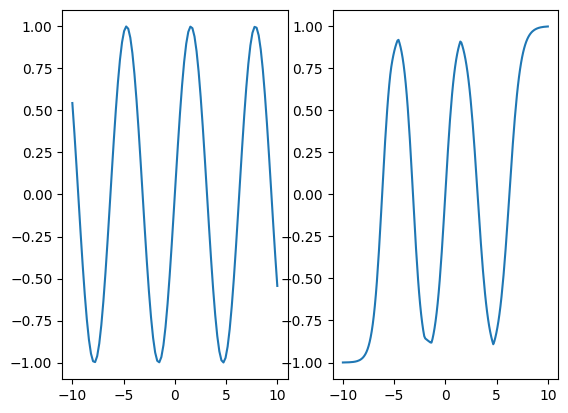

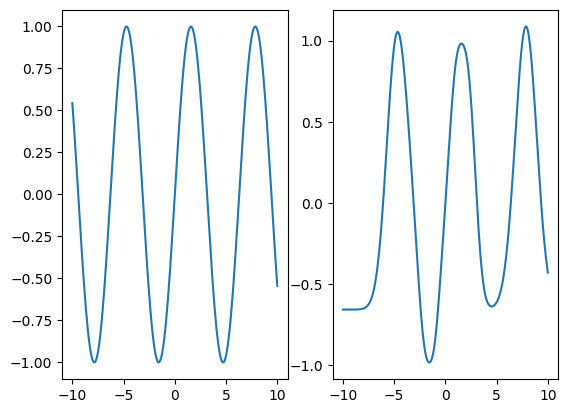

In [267]:
#Two alternatives to learn the sinus function:
network = MultilayerPerceptron(1)
network.add_dense_layer(16, ReLU())
network.add_dense_layer(1, Tanh())
learn_sinus(network, batch_size=100, epochs = 200, samples = 100)
network = network = MultilayerPerceptron(1)
network.add_dense_layer(50, Gaussian())
network.add_dense_layer(1, Linear(1))
learn_sinus(network, batch_size=50, epochs = 200, samples = 200)